# Comparison Opal data and ActiGraph data - detailed walking fragment

## Comparison

Data was collected simultaneously for walking in a lab setting (back and forth 10 times across a 30 m corridor) and while walking outside. The lab walk was more consistent speed, while the outside was varied (pausing, much more turning, up and down in elevation, etc).

Synchronization was performed by standing still for 10 seconds, jumping 3 times, standing still for another 10 seconds, and then starting the walking bout. Data was then manually synchronized to the jumping point in sync_imu_data.py.

In this file, let's inspect a detailed fragment of the lab walking data to see the effects of possible aliasing (and upsampling, because some algorithms use an internal sampling frequency of 40 Hz). Let's also run gait sequence detection, initial contact detection, cadence estimation and stride length estimation with MobGap functions and compare.

# Raw data

Below we read and visualize the raw data for the lab based walking bout (for 1 participant). Note that the Opal acceleration data is in m/s^2 and ActiGraph in units of g by default.

Using pq file data/apdm/apdm_subj1_lab_imu_data.parquet


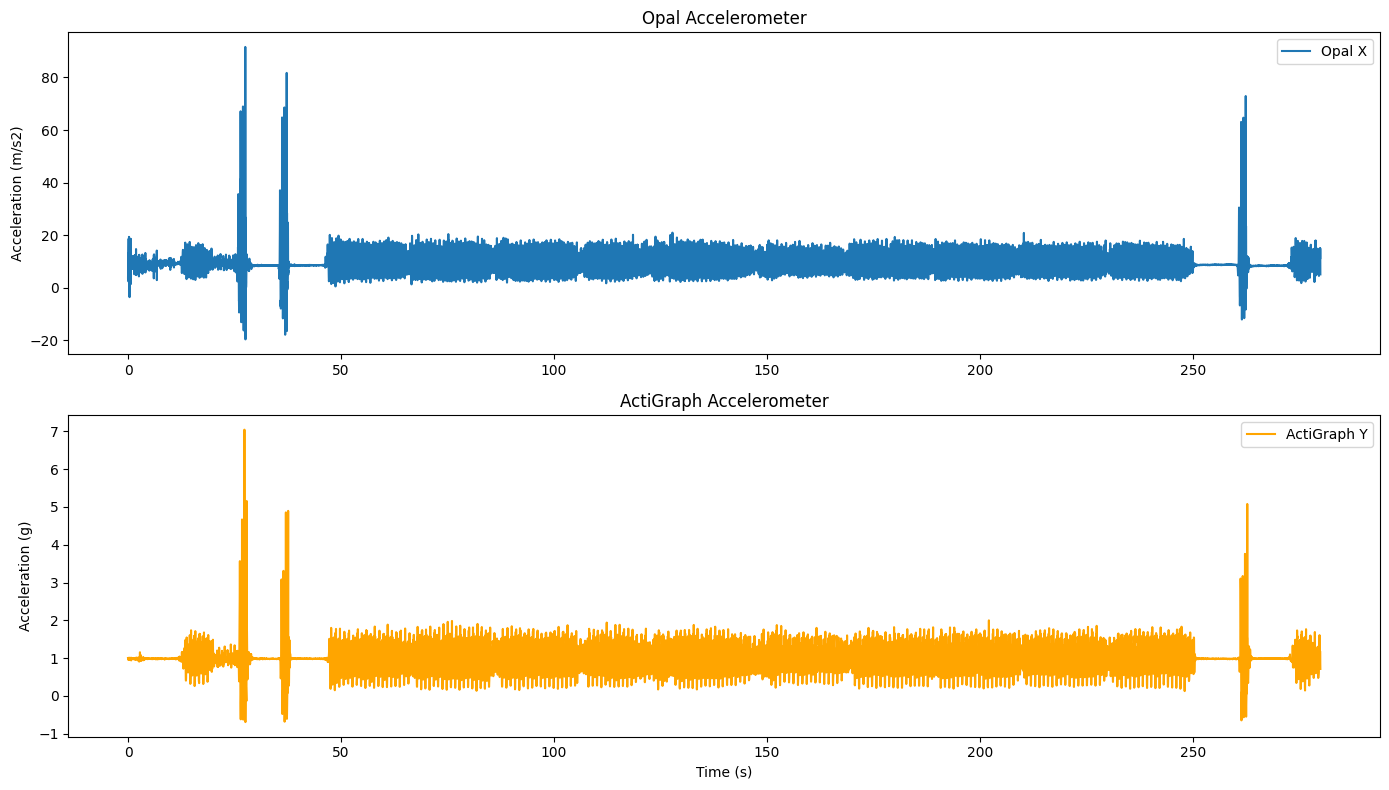

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Where all the data is stored
pq_file = "data/apdm/apdm_subj1_lab_imu_data.parquet"
csv_file = "data/actigraph/actigraph_subj1_lab/data_acc_trimmed.csv"

fs_opal = 128
fs_actigraph = 30
t_max = 280

# Get opal acc data for session
opal_imu_data = pd.read_parquet(pq_file)
session = "test"
seek_column = session + "/LUMBAR/Accelerometer"
acc_data_opal = opal_imu_data.filter(regex=seek_column).to_numpy()
print("Using pq file " + pq_file)

# Actigraph acc
actigraph_data = pd.read_csv(csv_file)
acc_data_actigraph = actigraph_data[['Accelerometer X', 'Accelerometer Y', 'Accelerometer Z']].to_numpy()

# Create time axes
t_actigraph = np.arange(0, len(acc_data_actigraph)) / fs_actigraph
t_opal = np.arange(0, len(acc_data_opal)) / fs_opal

# Trim end
acc_data_opal = acc_data_opal[0:t_max*fs_opal]
acc_data_actigraph = acc_data_actigraph[0:t_max*fs_actigraph]
t_opal = t_opal[0:t_max*fs_opal]
t_actigraph = t_actigraph[0:t_max*fs_actigraph]

#Plot in two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
axs[0].plot(t_opal, -acc_data_opal[:, 0], label='Opal X')
axs[0].set_title('Opal Accelerometer')
axs[0].set_ylabel('Acceleration (m/s2)')
axs[0].legend()
axs[1].plot(t_actigraph, acc_data_actigraph[:, 1], label='ActiGraph Y', color='orange')
axs[1].set_title('ActiGraph Accelerometer')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Acceleration (g)')
axs[1].legend()
plt.tight_layout()
plt.show()

# Comparison of bandpassed data

In the above graphs we can see the inital and final jumps. We will select a 20 second fragment to look in detail at the signal and what happens when we bandpass it to frequencies used in initial contact detection (in particular [_icd_ionescu.py](https://github.com/mobilise-d/mobgap/blob/e562c0addf677dae12768b9e269d71273b22ee92/src/mobgap/initial_contacts/_icd_ionescu.py)). 

We will plot the vertical acceleration signal (X axis for Opal, Y axis for ActiGraph) between 0.15 and 3.14 Hz.

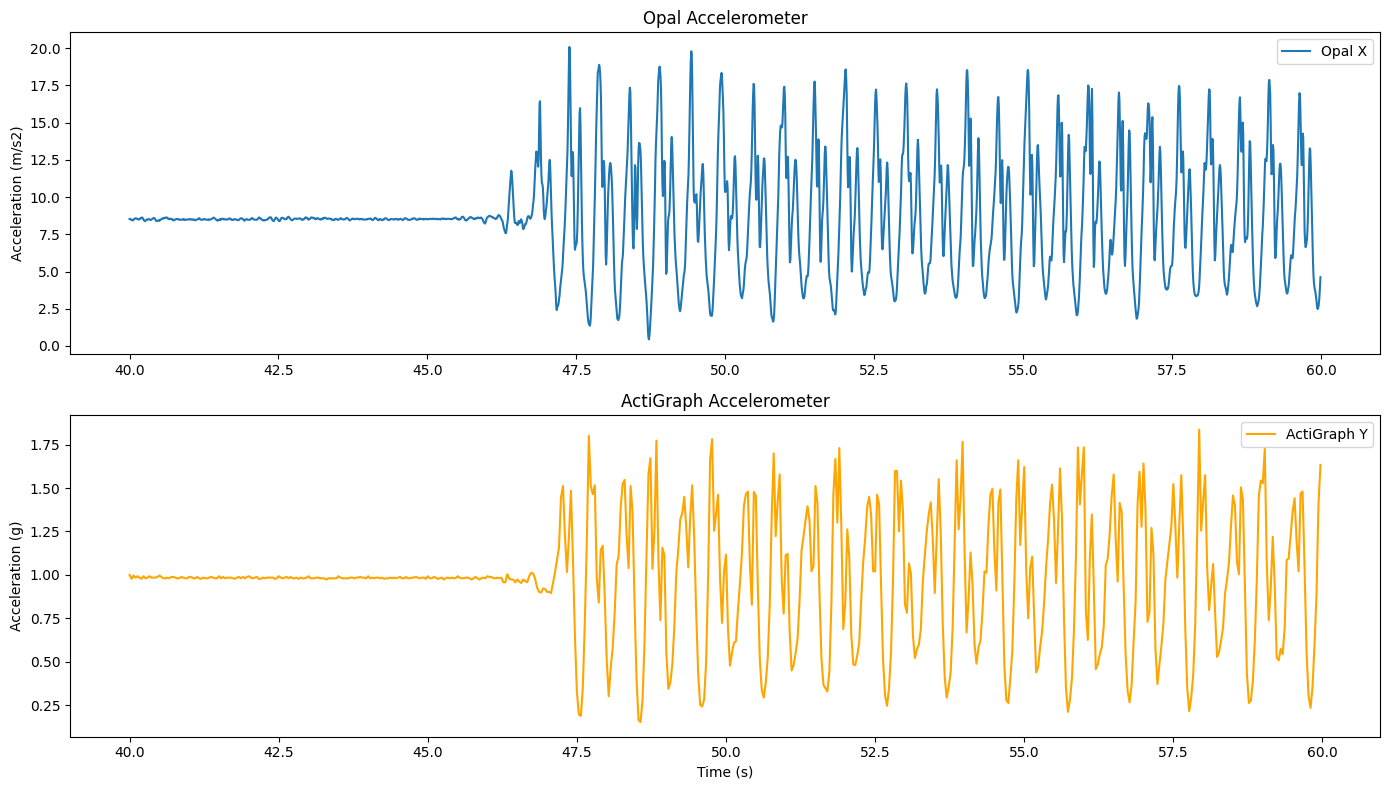

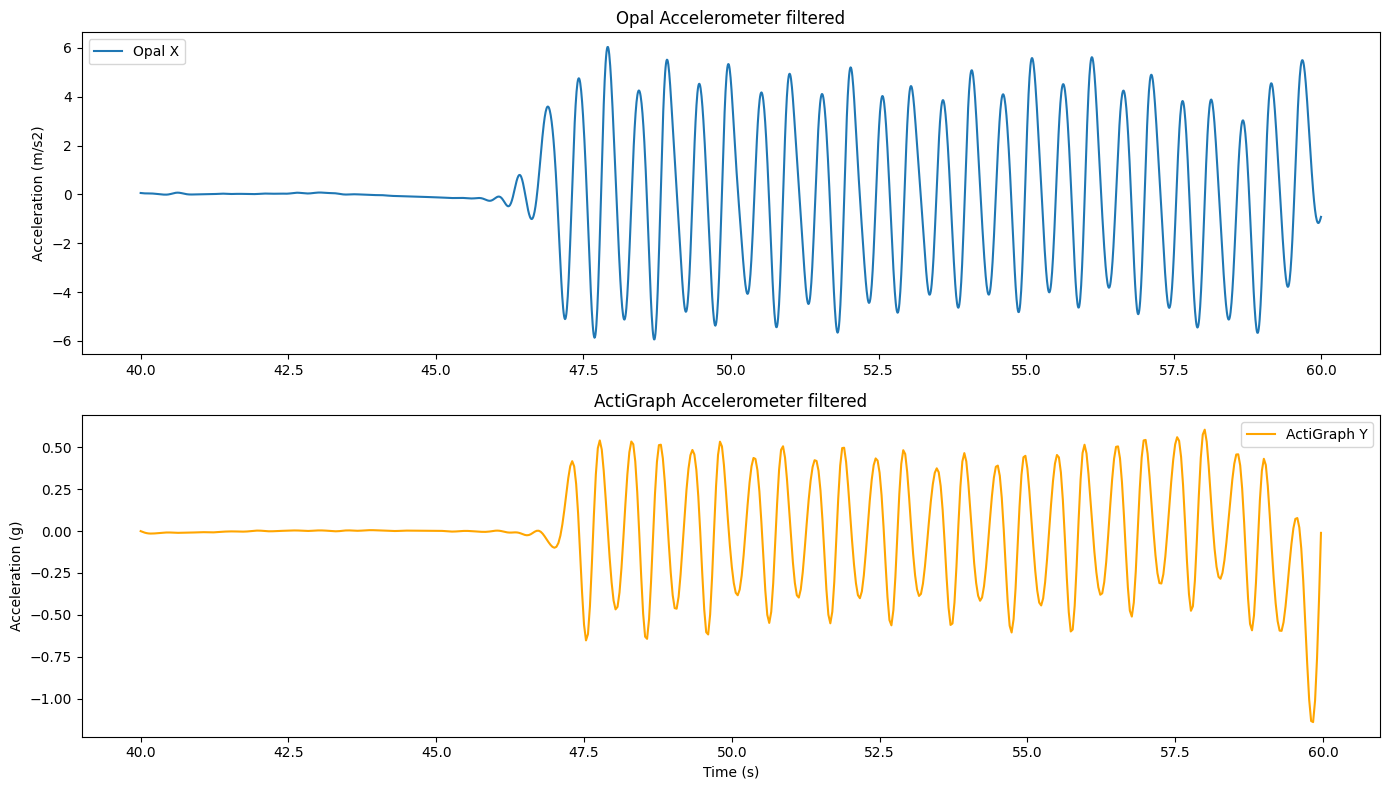

In [2]:
from scipy.signal import butter, filtfilt

# Compare a portion between 40 and 60 seconds.
acc_data_opal_window = acc_data_opal[40*fs_opal:60*fs_opal]
acc_data_actigraph_window = acc_data_actigraph[40*fs_actigraph:60*fs_actigraph]
t_opal_window = t_opal[40*fs_opal:60*fs_opal]
t_actigraph_window = t_actigraph[40*fs_actigraph:60*fs_actigraph]

#Plot in two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
axs[0].plot(t_opal_window, -acc_data_opal_window[:, 0], label='Opal X')
axs[0].set_title('Opal Accelerometer')
axs[0].set_ylabel('Acceleration (m/s2)')
axs[0].legend()
axs[1].plot(t_actigraph_window, acc_data_actigraph_window[:, 1], label='ActiGraph Y', color='orange')
axs[1].set_title('ActiGraph Accelerometer')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Acceleration (g)')
axs[1].legend()
plt.tight_layout()
plt.show()

# From https://github.com/mobilise-d/mobgap/blob/main/src/mobgap/initial_contacts/_icd_ionescu.py
# Resample to 40 Hz
# Band-pass filtering --> lower cut-off: 0.15 Hz; higher cut-off: 3.14 Hz
# Let's try the bandpass filtering and see how the resulting signals look.

low_cutoff = 0.15  # Hz
high_cutoff = 3.14  # Hz
order = 4

def bp_filter(fs, low_cutoff, high_cutoff, order, signal):

    # Normalize frequencies by Nyquist frequency
    nyquist = 0.5 * fs
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    
    # Design Butterworth band-pass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

acc_data_opal_window_filtered = bp_filter(fs_opal, low_cutoff, high_cutoff, order, -acc_data_opal_window[:, 0])
acc_data_actigraph_window_filtered = bp_filter(fs_actigraph, low_cutoff, high_cutoff, order, acc_data_actigraph_window[:, 1])

#Plot in two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
axs[0].plot(t_opal_window, acc_data_opal_window_filtered, label='Opal X')
axs[0].set_title('Opal Accelerometer filtered')
axs[0].set_ylabel('Acceleration (m/s2)')
axs[0].legend()
axs[1].plot(t_actigraph_window, acc_data_actigraph_window_filtered, label='ActiGraph Y', color='orange')
axs[1].set_title('ActiGraph Accelerometer filtered')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Acceleration (g)')
axs[1].legend()
plt.tight_layout()
plt.show()

We can see a very nice correspondance in the data, with the peaks looking similar.

# Comparison of 30 Hz and upsampled 40 Hz data

What are the effects of upsampling to 40 Hz?

Samples window original: 600
Samples window resampled: 800


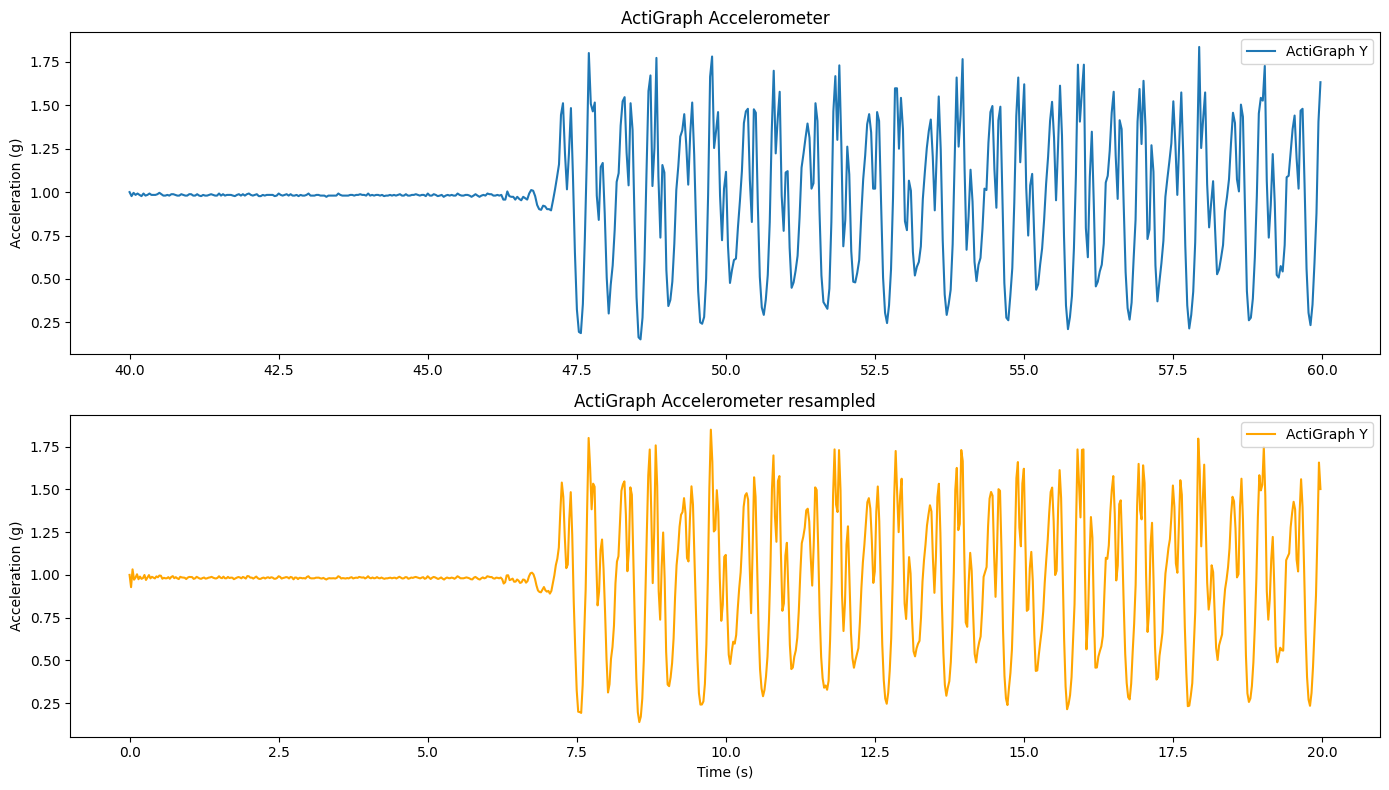

In [3]:
from scipy import signal

# Now let's upsample ActiGraph and run same mobgap on both?

# They do
# from scipy import signal
# resampling_factor = self.target_sampling_rate_hz / sampling_rate_hz
# new_n_samples = round(len(data_as_array) * resampling_factor)
# resampled_data = signal.resample(data, new_n_samples)
# https://github.com/mobilise-d/mobgap/blob/e562c0addf677dae12768b9e269d71273b22ee92/src/mobgap/initial_contacts/_hklee_algo_improved.py#L16
# Resample(self._UPSAMPLED_SAMPLING_RATE_HZ)

acc_data_actigraph_resampled = acc_data_actigraph_window[:, 1]
resampling_factor = 40 / fs_actigraph
new_n_samples = round(len(acc_data_actigraph_resampled) * resampling_factor)
acc_data_actigraph_resampled = signal.resample(acc_data_actigraph_resampled, new_n_samples)
t_actigraph_window_resampled = np.arange(0, len(acc_data_actigraph_resampled)) / 40

print(f"Samples window original: {len(acc_data_actigraph_window[:, 1])}")
print(f"Samples window resampled: {len(acc_data_actigraph_resampled)}")

#Plot in two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
axs[0].plot(t_actigraph_window, acc_data_actigraph_window[:, 1], label='ActiGraph Y')
axs[0].set_title('ActiGraph Accelerometer')
axs[0].set_ylabel('Acceleration (g)')
axs[0].legend()
axs[1].plot(t_actigraph_window_resampled, acc_data_actigraph_resampled, label='ActiGraph Y', color='orange')
axs[1].set_title('ActiGraph Accelerometer resampled')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Acceleration (g)')
axs[1].legend()
plt.tight_layout()
plt.show()

We have expanded the number of samples in the ActiGraph data but the acceleration trace looks pretty good still.

# Comparison of bandpassed data (ActiGraph resampled to 40 Hz) 

Let's bandpass again as above and see the effects of resampling.


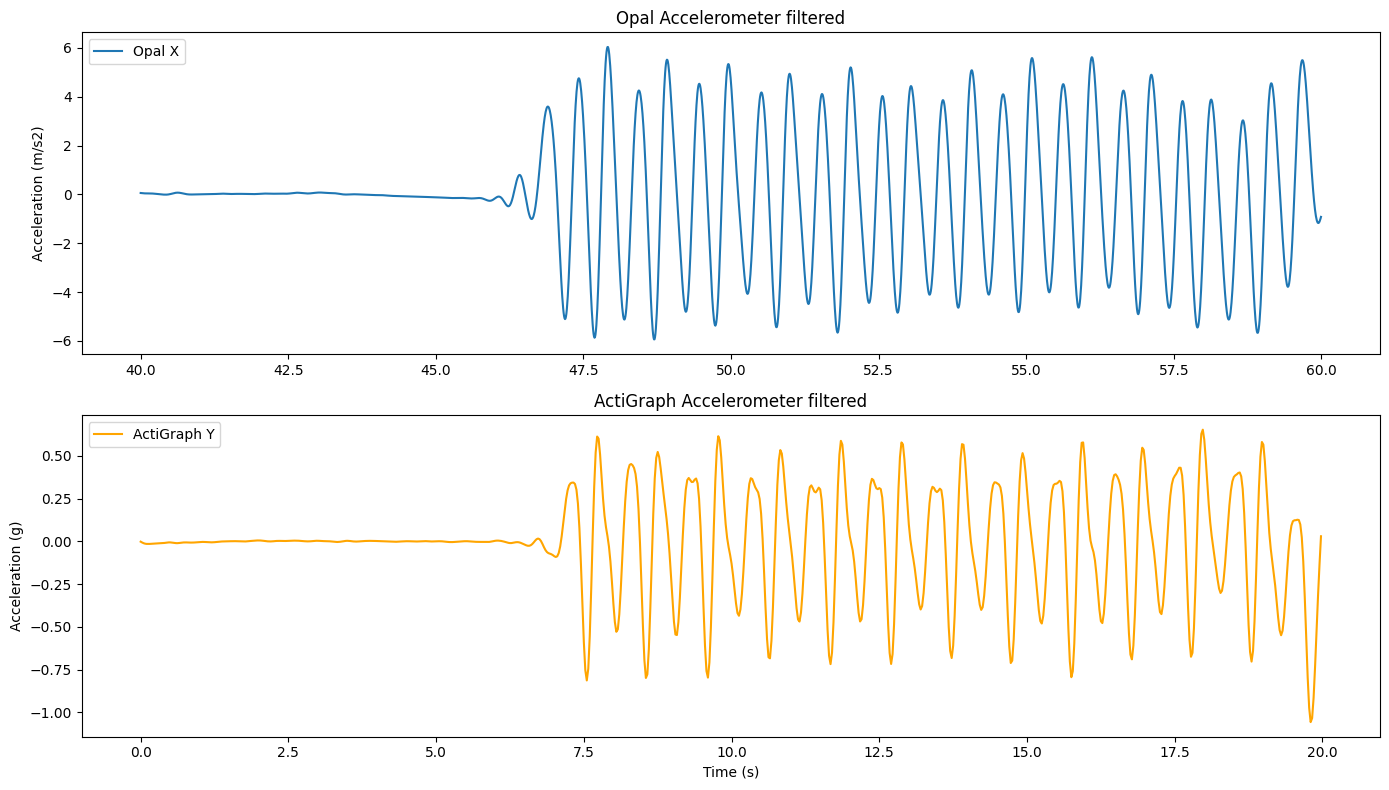

In [4]:
# Check the filtering again

acc_data_opal_window_filtered = bp_filter(fs_opal, low_cutoff, high_cutoff, order, -acc_data_opal_window[:, 0])
acc_data_actigraph_resampled_filtered = bp_filter(fs_actigraph, low_cutoff, high_cutoff, order, acc_data_actigraph_resampled)

#Plot in two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
axs[0].plot(t_opal_window, acc_data_opal_window_filtered, label='Opal X')
axs[0].set_title('Opal Accelerometer filtered')
axs[0].set_ylabel('Acceleration (m/s2)')
axs[0].legend()
axs[1].plot(t_actigraph_window_resampled, acc_data_actigraph_resampled_filtered, label='ActiGraph Y', color='orange')
axs[1].set_title('ActiGraph Accelerometer filtered')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Acceleration (g)')
axs[1].legend()
plt.tight_layout()
plt.show()

We can see that the peaks are a bit noisier because of the upsampling. They are probably good enough to be used, still.

# Preparing data

Let's put the data into proper MobGap dataframes before running their various algorithms.

We will just put gyroscope and magnetometer data to 0 for the ActiGraph.

       acc_x     acc_y     acc_z      gyr_x      gyr_y     gyr_z     mag_x  \
0     8.5316 -0.011581 -4.616441   0.180410  -0.799275  0.309335 -0.047700   
1     8.5330 -0.023781 -4.637441   0.299012  -0.506494  0.421635 -0.047903   
2     8.4984 -0.058981 -4.627241   0.190150  -0.547174  0.428511 -0.048018   
3     8.4733 -0.061081 -4.603541   0.588356  -0.146103  0.370642 -0.047920   
4     8.4719 -0.072581 -4.590641   0.669716  -0.642858  0.540810 -0.047718   
...      ...       ...       ...        ...        ...       ...       ...   
2555  2.6904 -1.446581 -0.902641  20.373162 -19.009593 -1.026229 -0.059017   
2556  2.9862 -1.268181 -0.914241  21.713310 -17.526778  1.456397 -0.059034   
2557  3.4181 -1.142081 -1.053941  23.001319 -15.765506  3.672598 -0.059035   
2558  3.9730 -0.950781 -1.165841  25.385396 -13.123025  6.164964 -0.058931   
2559  4.6152 -0.674781 -1.183441  28.642088  -7.597993  9.598700 -0.058821   

         mag_y     mag_z  samples  
0     0.012256  0.017346   

<Axes: >

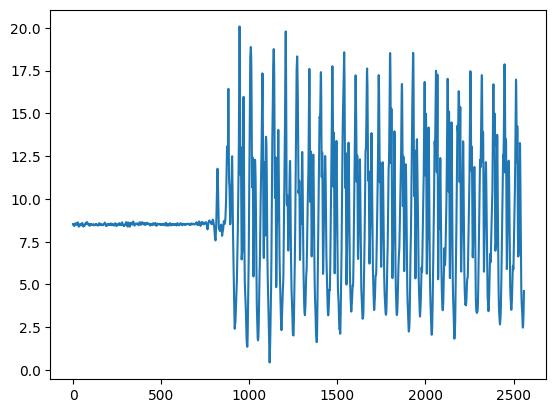

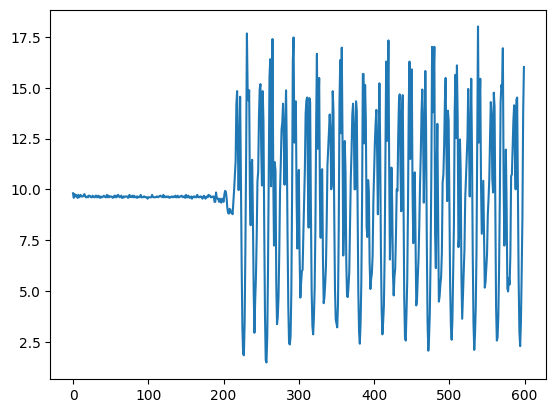

In [5]:
# Let's run something on the test window.

def extract_condition_data(imu_data, session, sensor_position, onset, duration, fs_imu):

    # Get session data
    seek_column = f"{session}/{sensor_position}/Accelerometer"
    acc_data = imu_data.filter(regex=seek_column).to_numpy()
    seek_column = f"{session}/{sensor_position}/Gyroscope"
    gyr_data = imu_data.filter(regex=seek_column).to_numpy()
    seek_column = f"{session}/{sensor_position}/Magnetometer"
    mag_data = imu_data.filter(regex=seek_column).to_numpy()

    onset_idx = onset*fs_imu
    end_idx = duration*fs_imu

    # Cut to window
    acc_data = acc_data[onset_idx:end_idx,:]
    gyr_data = gyr_data[onset_idx:end_idx,:]
    mag_data = mag_data[onset_idx:end_idx,:]

    # Convert magnetometer data from microT to milliT
    mag_data = mag_data / 1000

    # For lumbar: as opposed to gaitmap frame, keep the original Opal frame
    # but reverse axis. This aligns with mobgap example dataset acceleration directions.
    if sensor_position == "LUMBAR":
        acc_data = -acc_data
        gyr_data = -gyr_data
        mag_data = -mag_data

    # mobgap and gaitmap wants gyro in deg/s, not rad/s as we have
    gyr_data = gyr_data * 57.2957795

    return acc_data, gyr_data, mag_data

def construct_gaitmap_dataframe(fs_imu, acc_data, gyro_data = None, mag_data = None, is_actigraph = False):
    time_axis = np.arange(0, acc_data.shape[0]) / fs_imu

    if gyro_data is None:
        gyro_data = np.zeros(acc_data.shape)
    if mag_data is None:
        mag_data = np.zeros(acc_data.shape)

    # ActiGraphs have their data in units of g, we want m/s2
    if is_actigraph:
        acc_data = acc_data*9.81

    # ActiGraphs have their axes oriented differently than MobGap data
    # so we need to replace X and Y
    if is_actigraph:
        data = {
            "acc_x": acc_data[:,1],
            "acc_y": acc_data[:,0],
            "acc_z": acc_data[:,2],
            "gyr_x": gyro_data[:,1],
            "gyr_y": gyro_data[:,0],
            "gyr_z": gyro_data[:,2],
            "mag_x": mag_data[:,1],
            "mag_y": mag_data[:,0],
            "mag_z": mag_data[:,2]
        }
    else:
        data = {
            "acc_x": acc_data[:,0],
            "acc_y": acc_data[:,1],
            "acc_z": acc_data[:,2],
            "gyr_x": gyro_data[:,0],
            "gyr_y": gyro_data[:,1],
            "gyr_z": gyro_data[:,2],
            "mag_x": mag_data[:,0],
            "mag_y": mag_data[:,1],
            "mag_z": mag_data[:,2]
        }
    df = pd.DataFrame(data, index=time_axis)

    df['samples'] = range(len(df))
    df.index = range(len(df))
    
    return df


# Get acc data for session
acc_data_lumbar, gyro_data_lumbar, mag_data_lumbar = extract_condition_data(opal_imu_data, "test", "LUMBAR", 40, 60, fs_opal)
data_opal_window = construct_gaitmap_dataframe(fs_opal, acc_data_lumbar, gyro_data=gyro_data_lumbar, mag_data=mag_data_lumbar)
print(data_opal_window)

acc_data_actigraph_window = acc_data_actigraph[40*fs_actigraph:60*fs_actigraph]
data_actigraph_window = construct_gaitmap_dataframe(fs_actigraph, acc_data_actigraph_window, is_actigraph=True)
print(data_actigraph_window)

plt.figure()
data_opal_window["acc_x"].plot()
plt.figure()
data_actigraph_window["acc_x"].plot()


# Gait sequence detection

First we run gait sequence detection with GsdIluz. We should detect one segment (because this example data is just continuous walking).

       start   end
gs_id             
0        576  2497
       start  end
gs_id            
0        180  586


(<Figure size 640x480 with 1 Axes>, <Axes: >)

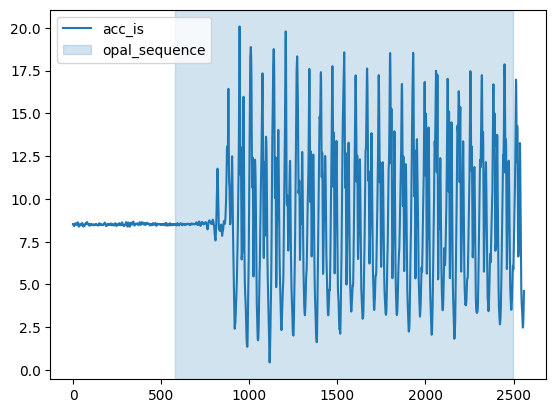

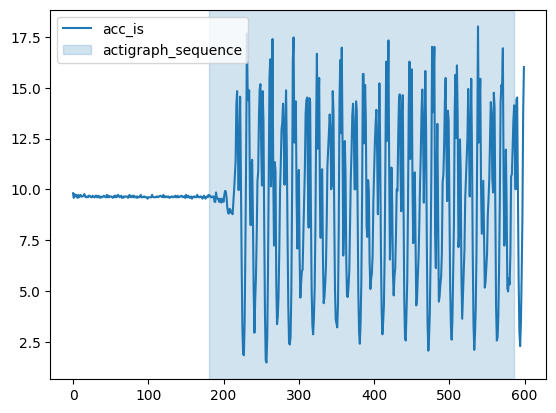

In [6]:
from mobgap.utils.conversions import to_body_frame
from mobgap.gait_sequences import GsdIluz


def plot_gsd_outputs(data, **kwargs):
    fig, ax = plt.subplots()

    ax.plot(data["acc_is"].to_numpy(), label="acc_is")

    color_cycle = iter(plt.rcParams["axes.prop_cycle"])

    y_max = 1.1
    plot_props = [
        {
            "data": v,
            "label": k,
            "alpha": 0.2,
            "ymax": (y_max := y_max - 0.1),
            "color": next(color_cycle)["color"],
        }
        for k, v in kwargs.items()
    ]

    for props in plot_props:
        for gsd in props.pop("data").itertuples(index=False):
            ax.axvspan(
                gsd.start, gsd.end, label=props.pop("label", None), **props
            )

    ax.legend()
    return fig, ax

data_opal_window_body = to_body_frame(data_opal_window)
data_actigraph_window_body = to_body_frame(data_actigraph_window)

gsd_opal = GsdIluz()
gsd_opal.detect(data=data_opal_window_body, sampling_rate_hz=fs_opal)
print(gsd_opal.gs_list_)

plot_gsd_outputs(data_opal_window_body, opal_sequence=gsd_opal.gs_list_)

gsd_actigraph = GsdIluz()
gsd_actigraph.detect(data=data_actigraph_window_body, sampling_rate_hz=fs_actigraph)
print(gsd_actigraph.gs_list_)

plot_gsd_outputs(data_actigraph_window_body, actigraph_sequence=gsd_actigraph.gs_list_)

We see that we find basically the same walking segment. Actually a bit worse in the Opal data. But it's one continuous segment.

# Initial contact detection

We will run IcdIonescu to find heel strikes in the data.

In [7]:
from mobgap.pipeline import GsIterator
from mobgap.initial_contacts import IcdIonescu

iterator = GsIterator()
for (gs, data), result in iterator.iterate(data_opal_window_body, gsd_opal.gs_list_):
    result.ic_list = (
        IcdIonescu().detect(data, sampling_rate_hz=fs_opal).ic_list_
    )
detected_ics_opal = iterator.results_.ic_list
print("OPAL")
print(detected_ics_opal)

iterator = GsIterator()
for (gs, data), result in iterator.iterate(data_actigraph_window_body, gsd_actigraph.gs_list_):
    result.ic_list = (
        IcdIonescu().detect(data, sampling_rate_hz=fs_actigraph).ic_list_
    )
detected_ics_actigraph = iterator.results_.ic_list
print("ACTIGRAPH")
print(detected_ics_actigraph)



OPAL
                 ic
gs_id step_id      
0     0         598
      1         659
      2         730
      3         803
      4         864
      5         938
      6        1002
      7        1069
      8        1133
      9        1200
      10       1264
      11       1334
      12       1398
      13       1466
      14       1530
      15       1597
      16       1661
      17       1728
      18       1792
      19       1859
      20       1923
      21       1990
      22       2051
      23       2118
      24       2182
      25       2250
      26       2310
      27       2378
      28       2442
ACTIGRAPH
                ic
gs_id step_id     
0     0        196
      1        214
      2        231
      3        246
      4        262
      5        277
      6        292
      7        308
      8        323
      9        339
      10       355
      11       370
      12       386
      13       400
      14       416
      15       431
      16       446
    

# Plot initial contact detection

Opal found 28 initial contacts but ActiGraph found 24. Let's plot them to see what they are.


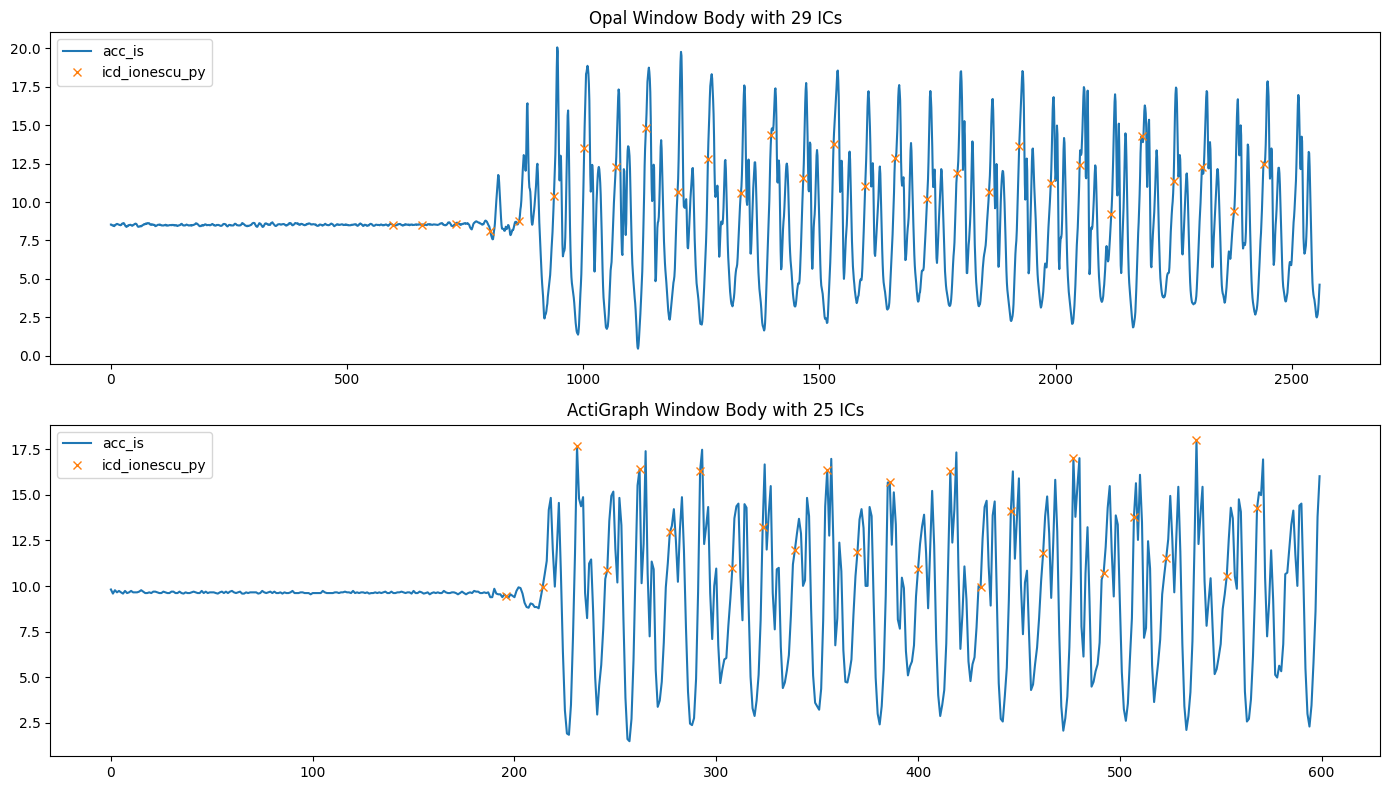

In [8]:

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# Plot for Opal data
axs[0].plot(data_opal_window_body['acc_is'], label='acc_is')
axs[0].plot(
    detected_ics_opal['ic'],
    data_opal_window_body['acc_is'].iloc[detected_ics_opal['ic']],
    'x',
    label='icd_ionescu_py'
)
axs[0].set_title(f"Opal Window Body with {len(detected_ics_opal['ic'])} ICs")
axs[0].legend()

# Plot for Actigraph data
axs[1].plot(data_actigraph_window_body['acc_is'], label='acc_is')
axs[1].plot(
    detected_ics_actigraph['ic'],
    data_actigraph_window_body['acc_is'].iloc[detected_ics_actigraph['ic']],
    'x',
    label='icd_ionescu_py'
)
axs[1].set_title(f"ActiGraph Window Body with {len(detected_ics_actigraph['ic'])} ICs")
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.show()


# Initial contact results

The extra initial contacts in the Opal data are from the noise in the beginning of detected gait sequence. We would probably have to modify the default parameters to detect it a bit better. But we have a pretty good correspondence. 

# Cadence estimation

Let's actually get some numbers for the step times (or cadences, which is the same thing obviously just scaled by a factor).

In [9]:
from mobgap.cadence import CadFromIc

# This is based on example
# https://mobgap.readthedocs.io/en/stable/auto_examples/cadence/_01_cad_from_ic.html

# Let's get the ICs
ics_opal = detected_ics_opal
ics_actigraph = detected_ics_actigraph

# We see that we don't want the first 4 ICs in opal data
ics_opal = ics_opal[4:]

# Estimate cadence
cad_from_ic = CadFromIc()
cad_from_ic.calculate(
    data_opal_window_body,
    initial_contacts=ics_opal,
    sampling_rate_hz=fs_opal,
)
print(cad_from_ic.cadence_per_sec_)
print(np.mean(cad_from_ic.cadence_per_sec_))

cad_from_ic = CadFromIc()
cad_from_ic.calculate(
    data_actigraph_window_body,
    initial_contacts=ics_actigraph,
    sampling_rate_hz=fs_actigraph,
)
print(cad_from_ic.cadence_per_sec_)
print(np.mean(cad_from_ic.cadence_per_sec_))

                    cadence_spm
sec_center_samples             
64                          NaN
192                         NaN
320                         NaN
448                         NaN
576                         NaN
704                         NaN
832                  117.251908
960                  117.251908
1088                 117.251908
1216                 117.251908
1344                 117.251908
1472                 117.251908
1600                 117.251908
1728                 117.251908
1856                 117.251908
1984                 117.251908
2112                 117.251908
2240                 120.000000
2368                 116.363636
2496                 120.000000
117.58104490928918
                    cadence_spm
sec_center_samples             
15                          NaN
45                          NaN
75                          NaN
105                         NaN
135                         NaN
165                         NaN
195                  

C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]


# Cadence results

We find an average cadence of 117.58 from the Opal data, and 116.73 from the ActiGraph data. Very promising!

# Stride length estimation

Stride length estimation is a more difficult task with the ActiGraph data because we need to double integrate data. Sensor height is estimated from participant height.

In [10]:
from mobgap.stride_length import SlZijlstra

# This is based on example
# https://mobgap.readthedocs.io/en/stable/auto_examples/stride_length/_01_sl_zijlstra.html
sensor_height = 1.76*0.53

# Opal
sl_zijlstra = SlZijlstra(
    **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
)
sl_zijlstra.calculate(
    data=data_opal_window_body,
    initial_contacts=ics_opal,
    sensor_height_m=sensor_height,
    sampling_rate_hz=fs_opal,
)
print(sl_zijlstra.stride_length_per_sec_)
print(np.mean(sl_zijlstra.stride_length_per_sec_))

# ActiGraph
sl_zijlstra = SlZijlstra(
    **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
)
sl_zijlstra.calculate(
    data=data_actigraph_window_body,
    initial_contacts=ics_actigraph,
    sensor_height_m=sensor_height,
    sampling_rate_hz=fs_actigraph,
)
print(sl_zijlstra.stride_length_per_sec_)
print(np.mean(sl_zijlstra.stride_length_per_sec_))


                    stride_length_m
sec_center_samples                 
64                              NaN
192                             NaN
320                             NaN
448                             NaN
576                             NaN
704                             NaN
832                        1.610149
960                        1.684339
1088                       1.638831
1216                       1.623343
1344                       1.584137
1472                       1.602469
1600                       1.521895
1728                       1.525089
1856                       1.562201
1984                       1.562308
2112                       1.540685
2240                       1.527870
2368                       1.507648
2496                       1.426154
1.5655083379970556
                    stride_length_m
sec_center_samples                 
15                              NaN
45                              NaN
75                              NaN
105      

C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(
C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(


# Results stride length estimation

We have an average of 1.566 m from the Opal data and an average of 1.569 from the ActiGraph data. This is very close.

BUT, we are not using global frame acceleration for the opal data. This might bias the results.

Note that a cadence of 117 steps/min and stride length of 1.58 m is average for males (https://ouhsc.edu/bserdac/dthompso/web/gait/knmatics/stride.htm).

# Stride length estimation with global frame

We will use MadgwickAHRS for the Opal data, and leave the ActiGraph data as-is, and compare.

In [11]:
from mobgap.orientation_estimation._madgwick import MadgwickAHRS

sensor_height = 1.76*0.53

# Opal
sl_zijlstra = SlZijlstra(
    orientation_method=MadgwickAHRS(beta=0.2),
    **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
)
sl_zijlstra.calculate(
    data=data_opal_window_body,
    initial_contacts=ics_opal,
    sensor_height_m=sensor_height,
    sampling_rate_hz=fs_opal,
)
print(sl_zijlstra.stride_length_per_sec_)
print(np.mean(sl_zijlstra.stride_length_per_sec_))

# ActiGraph
sl_zijlstra = SlZijlstra(
    **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
)
sl_zijlstra.calculate(
    data=data_actigraph_window_body,
    initial_contacts=ics_actigraph,
    sensor_height_m=sensor_height,
    sampling_rate_hz=fs_actigraph,
)
print(sl_zijlstra.stride_length_per_sec_)
print(np.mean(sl_zijlstra.stride_length_per_sec_))

                    stride_length_m
sec_center_samples                 
64                              NaN
192                             NaN
320                             NaN
448                             NaN
576                             NaN
704                             NaN
832                        1.645901
960                        1.712910
1088                       1.669921
1216                       1.628502
1344                       1.610283
1472                       1.623441
1600                       1.542677
1728                       1.563526
1856                       1.596177
1984                       1.600418
2112                       1.584023
2240                       1.561080
2368                       1.541204
2496                       1.519358
1.5999586607005687
                    stride_length_m
sec_center_samples                 
15                              NaN
45                              NaN
75                              NaN
105      

C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(
C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(


# Results stride length estimation global frame

The Opal stride lengths became slightly higher, 1.6 m, while the ActiGraph is at 1.57 m.

Still, a very good correspondence on very simple gait data for a fast walk.

Next we will compare the full dataset, and the outside data.